In [2]:
# import modules & set up logging
# import gensim, logging
# from sortedcontainers import SortedDict
# from gensim.models import KeyedVectors
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import unidecode
# import pickle
import re
from collections import defaultdict
# import random
import pandas as pd
# import numpy as np
# import seaborn as sns
# from tqdm import tqdm
# import glob, os
#import pybootstrap as pb
# from scipy.stats.stats import pearsonr
#import pymc3 as pm
# from scipy.spatial.distance import cosine as cosine_distance
# from aligning_embeddings import *
# from w2vtransformation import *
# from relation import *
from helper import *
# import zipfile
# import datetime
# import urllib.request
# import os.path
# from umap import UMAP # actually called "umap-learn"
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

In [3]:
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [194]:
#configure plotting
figures_path = '../figures/'
%matplotlib inline
plt.style.use('bmh')
plt.style.use('grayscale')


In [5]:
models = []
for year in range(1950,1995, int(5)):
    models.append(KeyedVectors.load_word2vec_format('/Users/melvinwevers/all/5/{}_{}.w2v'.
                                                        format(year, year+(5-1)),
                                                        binary=True))

In [6]:
def align_models(models):
    models[0].init_sims(replace=True) #l2 normalize
    for i in range(1, len(models)):
        models[i].init_sims(replace=True)
        models[i] = smart_procrustes_align_gensim(models[i - 1], models[i])
    return models

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(
        base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = in_base_embed.syn0norm
    other_vecs = in_other_embed.syn0norm

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs)
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.syn0norm = other_embed.syn0 = (other_embed.syn0norm).dot(ortho)
    return other_embed


def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
        The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.vocab.keys())
    vocab_m2 = set(m2.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words:
        common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1, m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(
        key=lambda w: m1.vocab[w].count + m2.vocab[w].count, reverse=True)

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.vocab[w].index for w in common_vocab]
        old_arr = m.syn0norm
        new_arr = np.array([old_arr[index] for index in indices])
        m.syn0norm = m.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.vocab
        new_vocab = {}
        for new_index, word in enumerate(common_vocab):
            old_vocab_obj = old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(
                index=new_index, count=old_vocab_obj.count)
        m.vocab = new_vocab

    return (m1, m2)

In [7]:
def cossim(v1, v2, signed = True):
    '''
    calculate cossimilarity between two vectors
    '''
    c = np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
    if not signed:
        return abs(c)
    return c

In [8]:
models_aligned = align_models(models)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-

In [9]:
def calc_distance_between_vectors(vec1, vec2, distype = 'norm'):
    if distype is 'norm':
        return np.linalg.norm(np.subtract(vec1, vec2))
    else:
        return cossim(vec1, vec2)

In [10]:
from scipy.spatial.distance import cosine

In [11]:
d = defaultdict(lambda: defaultdict(list))
target_words = ['abortus', 'democratie']
years = range(1955, 1995, 5)

for target_word in target_words:
    unique_words = []
    for index in range(0, len(models_aligned)-1):
        nearest_neighbors = [word for word,c in models_aligned[index].most_similar(target_word, topn=25)]
        for word in nearest_neighbors:
            unique_words.append(word)
    unique_words = list(set(unique_words))

    ## check if words exist in all models
    for word in unique_words:
        for index in range(0, len(models_aligned)-1):
            if word in models_aligned[index].vocab:
                continue
            else:
                try:
                    unique_words.remove(word)
                except:
                    print('already removed')

    ## get similarity vector for target word vs all other words
    vectors = {}
    for index in range(0, len(models_aligned)):
         vectors[index] = [models_aligned[index].similarity(target_word, w) for w in unique_words]

    for index in range(0, (len(models_aligned)-1)):
        d[target_word]['distance'].append(cossim(vectors[index], vectors[index+1]))

/usr/local/lib/python2.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


already removed
already removed
already removed
already removed
already removed
already removed
already removed
already removed


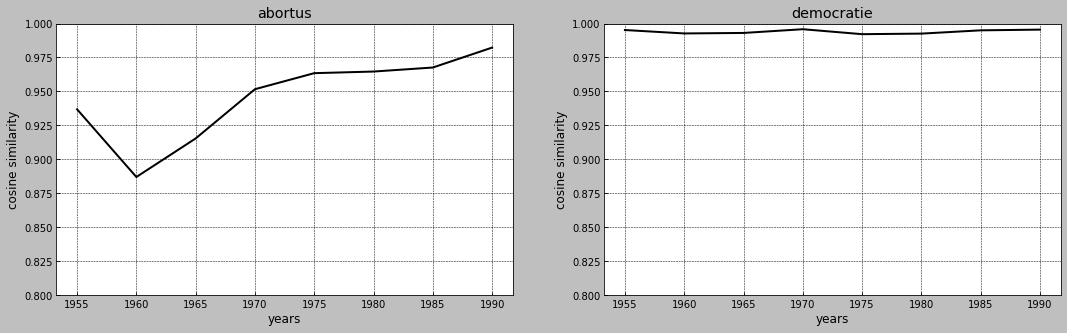

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

for ax, key in zip(axes, d.keys()):
    ax.plot(years, d[key]['distance'])
    ax.set_xlabel('years')
    ax.set_ylabel('cosine similarity')
    ax.set_title('{}'.format(key))
    ax.set_xticks(years)
    #ax.set_xticklabels(['1950','1955','1980'])
    ax.set_ylim([0.8,1])
    #plt.show()


plt.show()
fig.savefig('plot2.png', dpi=300, bbox_inches="tight")

In [12]:

d = defaultdict(lambda: defaultdict(list))


In [13]:
words = ['abortus', 'democratie']
for word in words:
    years = range(1955, 1995, 5)
    for index in range(0, len(models_aligned)-1):
    
        d[word]['distance'].append(cossim(models_aligned[index][word], models_aligned[index+1][word]))
        d[word]['counts'].append(int(models[index].vocab[word].count / 1000))

        

In [14]:
d

defaultdict(<function __main__.<lambda>>,
            {'abortus': defaultdict(list,
                         {'counts': [143, 170, 186, 201, 213, 221, 226, 235],
                          'distance': [0.51335555,
                           0.5931133,
                           0.58849317,
                           0.74009144,
                           0.84358066,
                           0.8036684,
                           0.8180463,
                           0.8097349]}),
             'democratie': defaultdict(list,
                         {'counts': [182, 195, 201, 208, 214, 222, 228, 238],
                          'distance': [0.8395956,
                           0.83506703,
                           0.8491857,
                           0.874008,
                           0.86124235,
                           0.8437812,
                           0.839895,
                           0.8655838]})})

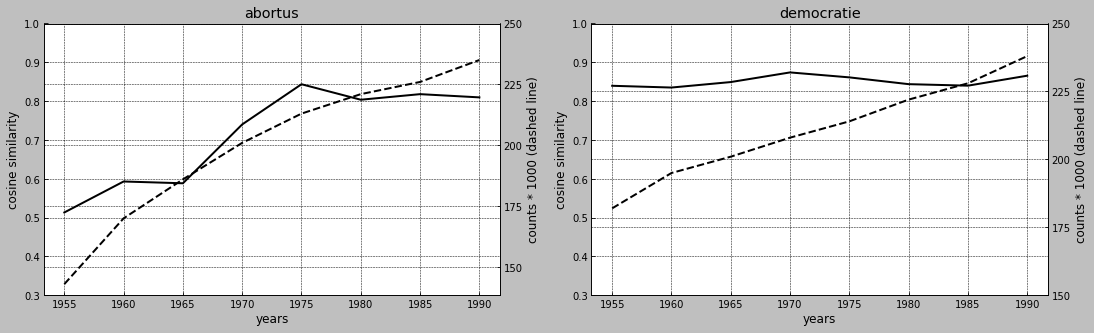

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

for ax, key in zip(axes, d.keys()):
    ax.plot(years, d[key]['distance'])
    ax.set_xlabel('years')
    ax.set_ylabel('cosine similarity')
    ax.set_title('{}'.format(key))
    ax.set_xticks(years)
    #ax.set_xticklabels(['1950','1955','1980'])
    ax.set_ylim([0.3,1])
    #plt.show()

    ax2 = ax.twinx()
    ax2.plot(years, d[key]['counts'], linestyle='--')
    #ax2.set_ylim(0, 200000)
    ax2.yaxis.set_ticks(np.arange(150, 275, 25))
    ax2.set_ylabel('counts * 1000 (dashed line)')

plt.show()
fig.savefig('plot1.png', dpi=300, bbox_inches="tight")

In [347]:
nn = models[8].most_similar('abortus')

In [348]:
import networkx as nx
G=nx.Graph()

In [349]:
for n in nn:
    G.add_node('abortus')
    G.add_node(n[0])
    G.add_edge('abortus', n[0], weight=n[1])

In [350]:
G.edges(data=True)

EdgeDataView([(u'voorbehoedmiddelen', 'abortus', {'weight': 0.5961788892745972}), (u'geboorteregeling', 'abortus', {'weight': 0.5577507019042969}), (u'voorbehoedsmiddelen', 'abortus', {'weight': 0.5744156837463379}), (u'ongeboren', 'abortus', {'weight': 0.5064685344696045}), (u'euthanasie', 'abortus', {'weight': 0.6331584453582764}), (u'sterilisatie', 'abortus', {'weight': 0.5813156366348267}), (u'gezinsplanning', 'abortus', {'weight': 0.5130438804626465}), ('abortus', u'zwangerschap', {'weight': 0.5826597213745117}), ('abortus', u'geboortebeperking', {'weight': 0.5376343727111816}), ('abortus', u'anticonceptie', {'weight': 0.5628275871276855})])

In [352]:
mapping={'abortus':'abortion', 
         'voorbehoedmiddelen': 'contraceptives',
         'geboorteregeling': 'birth\ncontrol',
         'voorbehoedsmiddelen': 'contraceptives',
         'gezinsplanning': 'family planning',
         'geboortebeperking': 'birth\ncontrol',
         'infectie': 'infection',
         'ziekte': 'disease',
         'ziekten': 'diseases',
         'tuberculose': 'tuberculosis',
         'hondsdolheid': 'rabies',
         'dierenziekten': 'animal\ndiseases',
         'besmetting': 'contamination',
         'sterftegevallen': 'deaths',
         'ziektegevallen':'cases\nof illness',
         'echtscheiding':'divorce',
        'legalisatie': 'legalization',
         'legalisering': 'legalization',
        'zwangerschappen': 'pregnancies',
        'euthanasie': 'euthanasia',
        'zwangerschap': 'pregnancy',
         'ongeboren': 'unborn',
        'anticonceptie': 'anticonception',
        'sterilisatie': 'sterilization'}
G=nx.relabel_nodes(G,mapping)
print(sorted(H.nodes()))

['abortion', 'animal diseases', 'cases of illness', 'contamination', 'deaths', 'infection', 'rabies', u'tbc', 'tuberculosis', u'ziekte', u'ziekten']


In [353]:
edges=[(u,v) for (u,v,d) in G.edges(data=True)]

pos=nx.spring_layout(G) # positions for all nodes

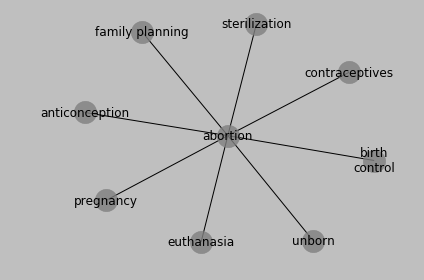

In [354]:
nx.draw_networkx_nodes(G,pos,node_size=500, node_color='grey', alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,edgelist=edges,
                    width=1)

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')



plt.axis('off')
plt.tight_layout()
plt.style.use('bmh')
plt.style.use('grayscale')
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.15
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.savefig("weighted_graph_1990.png") # save as png
plt.show() # display

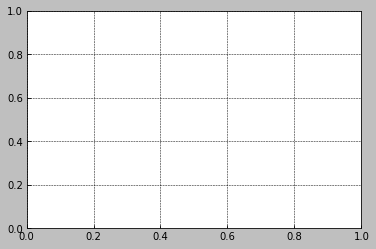

In [336]:
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

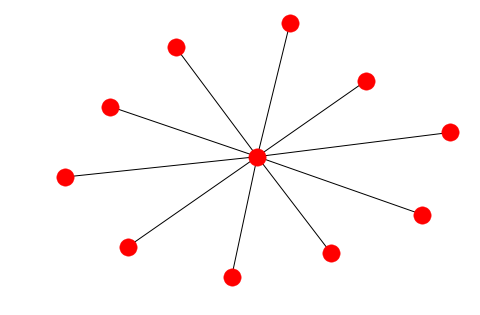

In [93]:
nx.draw(G)

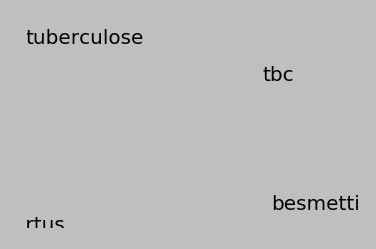

In [90]:
# edges
# nx.draw_networkx_edges(G,pos,edgelist=elarge,
#                     width=6)
# nx.draw_networkx_edges(G,pos,edgelist=esmall,
#                     width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')


plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display